# Import packages

In [255]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import glob
import PIL.Image as Image
import time

Check that you are using the GPU

In [256]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


**Important**

Ensure that your path is the same as below

In [257]:
data_dir = '/kaggle/input/hotdog-nothotdog/hotdog_nothotdog'

In [258]:
print(data_dir)

/kaggle/input/hotdog-nothotdog/hotdog_nothotdog


In [259]:
# code taken from https://saturncloud.io/blog/how-to-normalize-image-dataset-using-pytorch/

def get_mean_std(loader):
    # Compute the mean and standard deviation of all pixels in the dataset
    num_pixels = 0
    mean = 0.0
    std = 0.0
    for images, _ in loader:
        batch_size, num_channels, height, width = images.shape
        num_pixels += batch_size * height * width
        mean += images.mean(axis=(0, 2, 3)).sum()
        std += images.std(axis=(0, 2, 3)).sum()

    mean /= num_pixels
    std /= num_pixels

    return mean, std

The code below is copied from exercise 4

In [260]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):image_classes
    def __init__(self, train, transform, data_path=data_dir):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')


        # Debug: Print the paths being loaded
        print(f"Loading from path: {data_path}")
        print(f"Number of images found: {len(self.image_paths)}")
        print(f"Sample paths: {self.image_paths[:5]}")  # print first 5 image paths for inspection

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]

        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

IndentationError: unexpected indent (565086469.py, line 2)

In [261]:
SIZE = 128
BATCH_SIZE = 64

temp_transform = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.ToTensor(),
])

trainset_temp = Hotdog_NotHotdog(train=True, transform=temp_transform)
train_loader_temp = DataLoader(trainset_temp, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

mean, std = get_mean_std(train_loader_temp)

Loading from path: /kaggle/input/hotdog-nothotdog/hotdog_nothotdog/train
Number of images found: 2047
Sample paths: ['/kaggle/input/hotdog-nothotdog/hotdog_nothotdog/train/hotdog/hotdog (99).jpg', '/kaggle/input/hotdog-nothotdog/hotdog_nothotdog/train/hotdog/hotdog (107).jpg', '/kaggle/input/hotdog-nothotdog/hotdog_nothotdog/train/hotdog/frankfurter (225).jpg', '/kaggle/input/hotdog-nothotdog/hotdog_nothotdog/train/hotdog/chilidog (74).jpg', '/kaggle/input/hotdog-nothotdog/hotdog_nothotdog/train/hotdog/chilidog (191).jpg']


In [262]:
print(f"Mean: {mean}, std: {std}")

Mean: 1.2615616924449569e-06, std: 7.677089683966187e-07


In [263]:
train_transform = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transform = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

Loading from path: /kaggle/input/hotdog-nothotdog/hotdog_nothotdog/train
Number of images found: 2047
Sample paths: ['/kaggle/input/hotdog-nothotdog/hotdog_nothotdog/train/hotdog/hotdog (99).jpg', '/kaggle/input/hotdog-nothotdog/hotdog_nothotdog/train/hotdog/hotdog (107).jpg', '/kaggle/input/hotdog-nothotdog/hotdog_nothotdog/train/hotdog/frankfurter (225).jpg', '/kaggle/input/hotdog-nothotdog/hotdog_nothotdog/train/hotdog/chilidog (74).jpg', '/kaggle/input/hotdog-nothotdog/hotdog_nothotdog/train/hotdog/chilidog (191).jpg']
Loading from path: /kaggle/input/hotdog-nothotdog/hotdog_nothotdog/test
Number of images found: 1862
Sample paths: ['/kaggle/input/hotdog-nothotdog/hotdog_nothotdog/test/hotdog/hotdog (99).jpg', '/kaggle/input/hotdog-nothotdog/hotdog_nothotdog/test/hotdog/hotdog (107).jpg', '/kaggle/input/hotdog-nothotdog/hotdog_nothotdog/test/hotdog/frankfurter (225).jpg', '/kaggle/input/hotdog-nothotdog/hotdog_nothotdog/test/hotdog/chilidog (74).jpg', '/kaggle/input/hotdog-nothotdo

In [264]:
print(f'The number of images in training set is: {len(trainset)}')
print(f'The number of images in test set is: {len(testset)}')

The number of images in training set is: 2047
The number of images in test set is: 1862


torch.Size([64, 3, 128, 128])


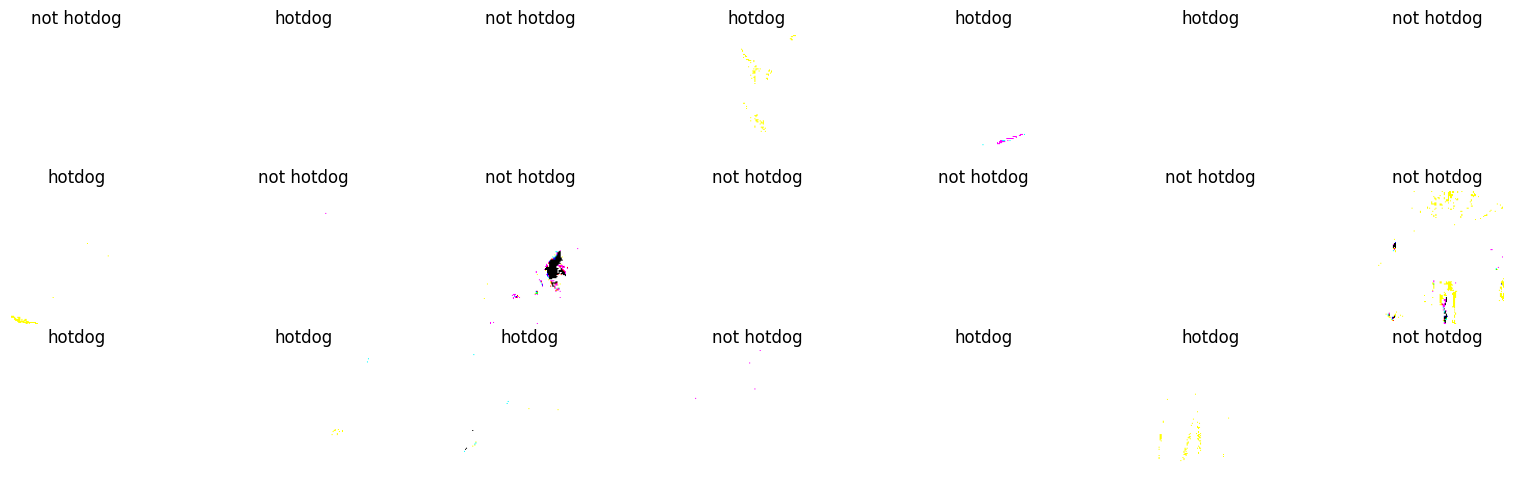

In [265]:
images, labels = next(iter(train_loader))
print(images.size())
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


In [266]:
class BaselineCNN(nn.Module):
  def __init__(self):
    super(BaselineCNN, self).__init__()
    self.convolutional = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1),
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1),
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1),
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1),
        nn.BatchNorm2d(8),
        nn.ReLU()
       )

    self.fully_connected = nn.Sequential(
        nn.Linear(64*64*8, 500),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(500, 2)
      )

  def forward(self, x):
    x = self.convolutional(x)
    x = x.view(x.size(0), -1)
    x = self.fully_connected(x)
    return x

In [267]:
model = BaselineCNN()
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)


In [268]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    def loss_fun(output, target):
        return F.cross_entropy(output, target)
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}

    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

In [269]:
t0 = time.time()
print(t0)
out_dict = train(model, optimizer)
print(f'Training time: {time.time() - t0}')

1727350185.534371


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 1.036	 test: 0.653	 Accuracy train: 55.3%	 test: 61.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.642	 test: 0.733	 Accuracy train: 64.1%	 test: 58.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.592	 test: 0.595	 Accuracy train: 69.9%	 test: 68.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.561	 test: 0.590	 Accuracy train: 73.3%	 test: 70.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.519	 test: 0.537	 Accuracy train: 75.1%	 test: 72.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.507	 test: 0.632	 Accuracy train: 74.7%	 test: 70.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.490	 test: 0.596	 Accuracy train: 76.7%	 test: 72.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.453	 test: 0.601	 Accuracy train: 79.1%	 test: 72.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.402	 test: 0.609	 Accuracy train: 82.0%	 test: 73.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.339	 test: 0.583	 Accuracy train: 84.2%	 test: 74.4%
Training time: 159.6357114315033


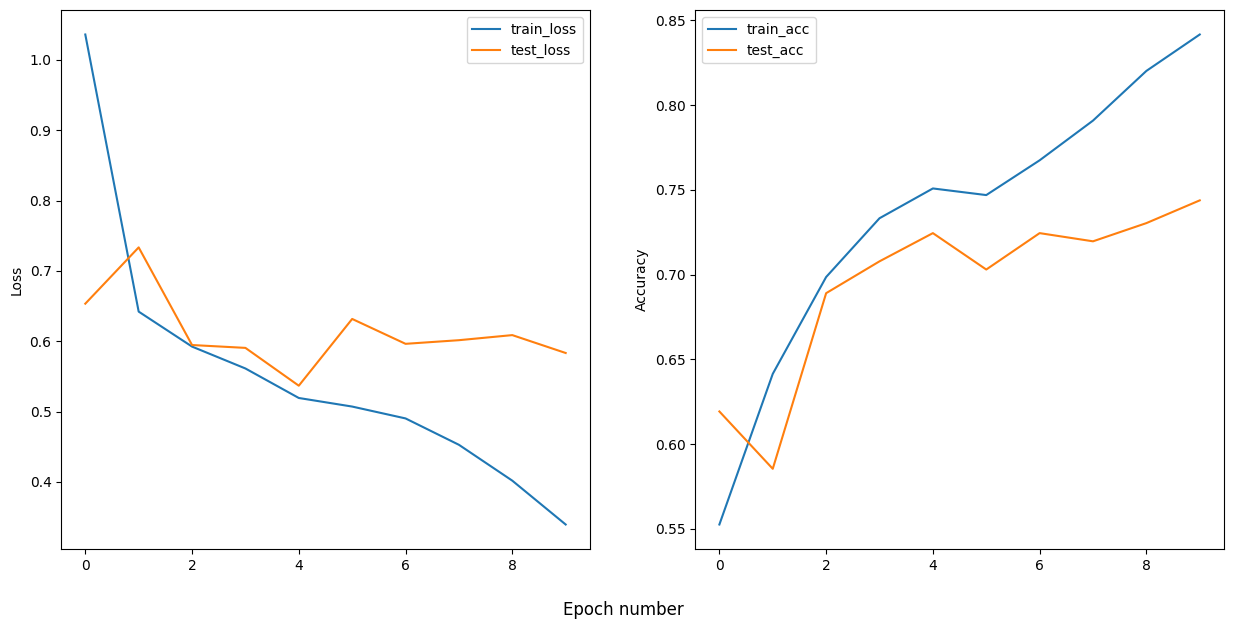

In [270]:
epochs = len(out_dict['train_acc'])

fig, ax = plt.subplots(figsize=(15, 7), ncols=2)
ax[0].plot(range(epochs), out_dict['train_loss'], label='train_loss' )
ax[0].plot(range(epochs), out_dict['test_loss'], label='test_loss' )
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(range(epochs), out_dict['train_acc'], label='train_acc')
ax[1].plot(range(epochs), out_dict['test_acc'], label='test_acc')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

fig.supxlabel('Epoch number')

plt.show()


## Salience map

In [271]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register a forward hook to capture activations
        self.target_layer.register_forward_hook(self.save_activations)
        
        # Register a backward hook to capture gradients
        self.target_layer.register_full_backward_hook(self.save_gradients)
    
    def save_activations(self, module, input, output):
        self.activations = output  # Save activations from the target layer
    
    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]  # Save gradients during backpropagation
    
    def __call__(self, x, index=None):
        # Forward pass
        output = self.model(x)
        if index is None:
            index = torch.argmax(output)
        
        # Backward pass
        self.model.zero_grad()
        output[:, index].backward()  # Backpropagate for the specific class
        
        # Check if activations were captured properly
        if self.activations is None:
            raise ValueError("Activations not captured. Check if the forward hook is registered properly.")
        
        # Get pooled gradients and create a Grad-CAM map
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        for i in range(self.activations.size(1)):
            self.activations[:, i, :, :] *= pooled_gradients[i]
        
        heatmap = torch.mean(self.activations, dim=1).squeeze().detach().cpu().numpy()
        heatmap = np.maximum(heatmap, 0)  # ReLU over heatmap
        heatmap /= np.max(heatmap)  # Normalize between 0 and 1
        return heatmap


In [272]:
model.to(device)
model.eval()  

# Identify the last convolutional layer in the model
target_layer = model.convolutional[-1]  # The last Conv2d layer in the sequential block

# Create Grad-CAM object
grad_cam = GradCAM(model, target_layer)


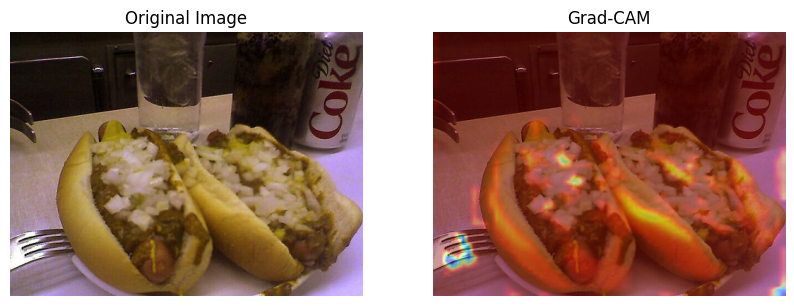

In [275]:
# Load and preprocess the image
img_path = '/kaggle/input/hotdog-nothotdog/hotdog_nothotdog/train/hotdog/chilidog (114).jpg'
image = Image.open(img_path).convert('RGB')
image_tensor = test_transform(image).unsqueeze(0).to(device)  # Prepare image tensor and move to GPU/CPU



# Generate Grad-CAM heatmap
heatmap = grad_cam(image_tensor)

# Resize the heatmap to match the image size
heatmap = cv2.resize(heatmap, (image.size[0], image.size[1]))

# Overlay the heatmap onto the original image
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Convert image to numpy array for overlay
image_np = np.array(image)
overlay_img = cv2.addWeighted(image_np, 0.6, heatmap, 0.4, 0)




# Plot the original image and the Grad-CAM heatmap
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Original Image")
plt.axis('off')

# Grad-CAM overlay
plt.subplot(1, 2, 2)
plt.imshow(overlay_img)
plt.title("Grad-CAM")
plt.axis('off')

plt.show()
